# Description

Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: The goal of this competition is to predict the age of abalone from various physical measurements.

https://www.kaggle.com/competitions/playground-series-s4e4

In [483]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression  # Can be any model of your choice
from sklearn.metrics import mean_squared_log_error
import math
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, IsolationForest
)
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score,
    average_precision_score, roc_curve, auc
)
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# EDA

In [432]:
from google.colab import drive
drive.mount('/content/drive')

train_file_path = '/content/drive/MyDrive/Regression_with_an_Abalone_Dataset/train.csv'
df_train = pd.read_csv(train_file_path)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [433]:
reduce_mem_usage(df_train)

Mem. usage decreased to  2.33 Mb (66.2% reduction)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.549805,0.429932,0.150024,0.771484,0.328613,0.146484,0.239990,11
1,1,F,0.629883,0.489990,0.145020,1.129883,0.458008,0.276611,0.320068,11
2,2,I,0.160034,0.109985,0.024994,0.020996,0.005501,0.003000,0.005001,6
3,3,M,0.595215,0.475098,0.150024,0.914551,0.375488,0.205444,0.250000,10
4,4,I,0.555176,0.425049,0.130005,0.782227,0.369385,0.160034,0.197510,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.334961,0.234985,0.075012,0.158447,0.068481,0.036987,0.045013,6
90611,90611,M,0.555176,0.425049,0.150024,0.878906,0.386475,0.181519,0.239990,9
90612,90612,I,0.435059,0.330078,0.094971,0.321533,0.151001,0.078491,0.081482,6
90613,90613,I,0.344971,0.270020,0.075012,0.199951,0.098022,0.049011,0.070007,6


Understanding Abalone Dataset Features
Let's quickly review the key features of the Abalone dataset:

Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [434]:
df = df_train.copy()

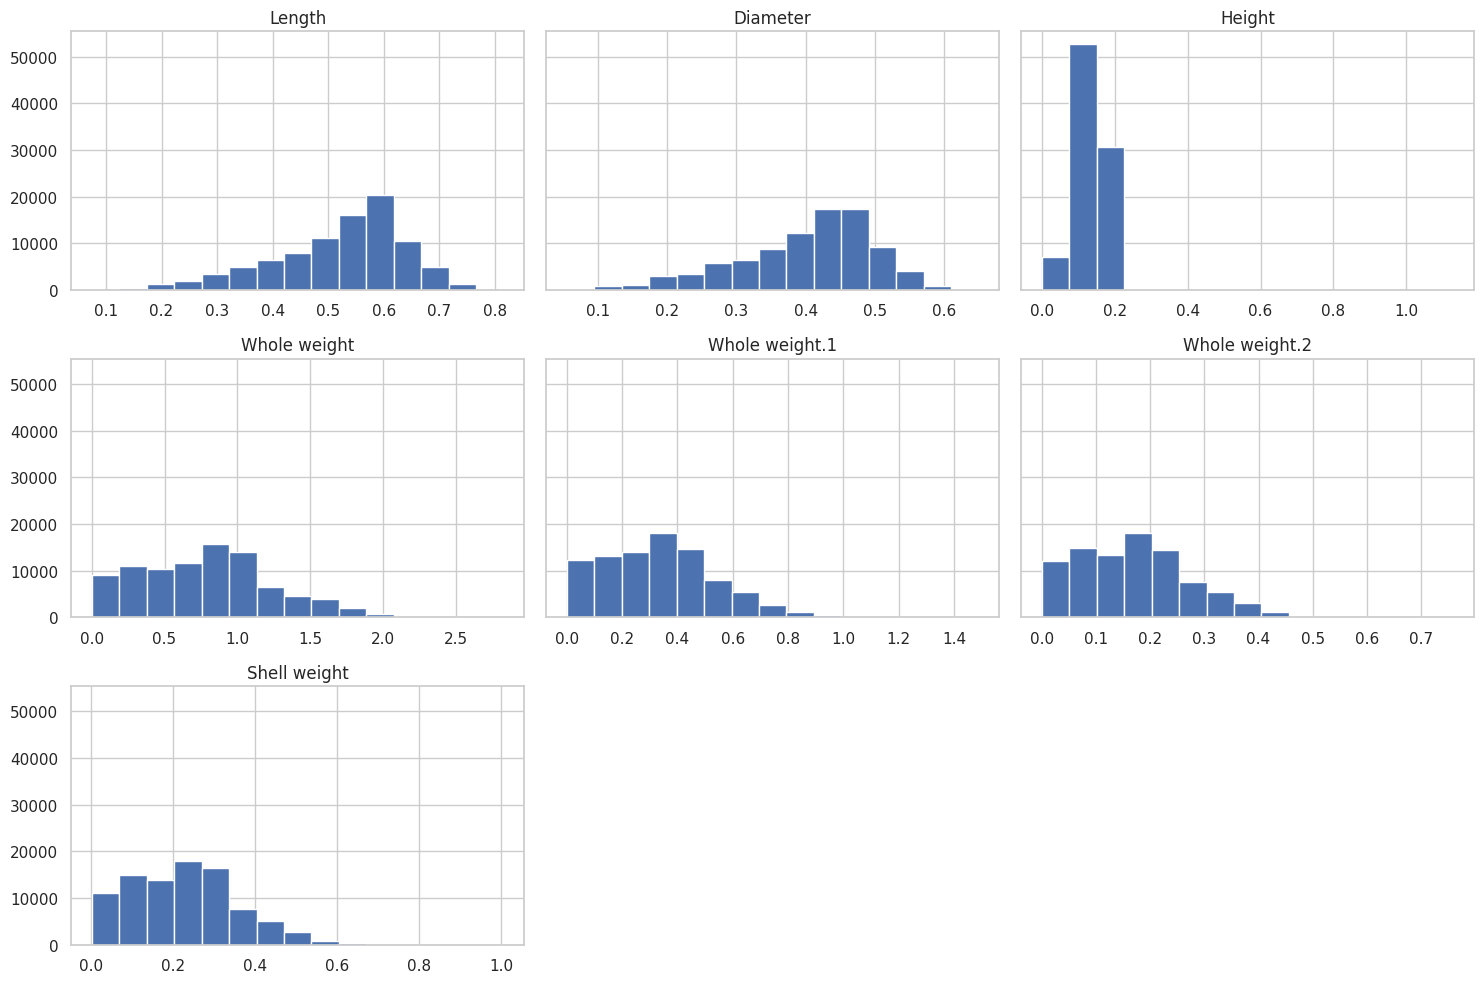

In [435]:
# defining target, dropping 'id' column
y = df['Rings']
df_train = df_train.drop(['id', 'Rings'], axis=1)

# Plotting histograms for each column in df_train
df_train.hist(bins=15, figsize=(15, 10), layout=(-1, 3), sharey=True, sharex=False)
plt.tight_layout()
plt.show()


<Axes: >

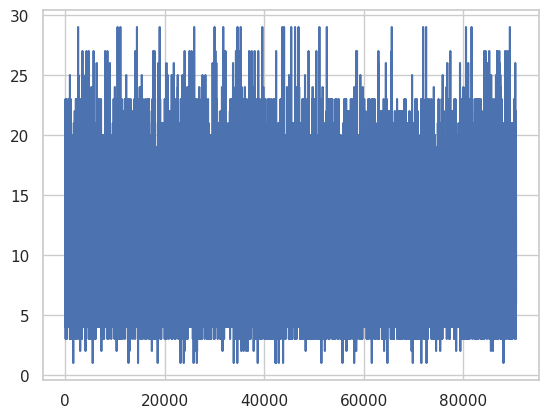

In [436]:
# plot distribution of target values
y.plot()

In [437]:
df_train.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.075012,0.054993,0.000000,0.002001,0.001000,0.000500,0.001500
25%,0.445068,0.344971,0.109985,0.418945,0.177490,0.086487,0.119995
50%,0.544922,0.425049,0.140015,0.799316,0.330078,0.166016,0.224976
75%,0.600098,0.469971,0.160034,1.067383,0.462891,0.232544,0.304932
max,0.814941,0.649902,1.129883,2.826172,1.488281,0.759766,1.004883


In [438]:
df_train.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64

In [439]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float16
 2   Diameter        90615 non-null  float16
 3   Height          90615 non-null  float16
 4   Whole weight    90615 non-null  float16
 5   Whole weight.1  90615 non-null  float16
 6   Whole weight.2  90615 non-null  float16
 7   Shell weight    90615 non-null  float16
dtypes: float16(7), object(1)
memory usage: 1.9+ MB


In [440]:
df_train['Sex'].unique()

array(['F', 'I', 'M'], dtype=object)

In [441]:
# Define a mapping from category to desired number
sex_mapping = {'F': 1, 'M': 0, 'I': 2}
df_train['Sex'] = df_train['Sex'].replace(sex_mapping)

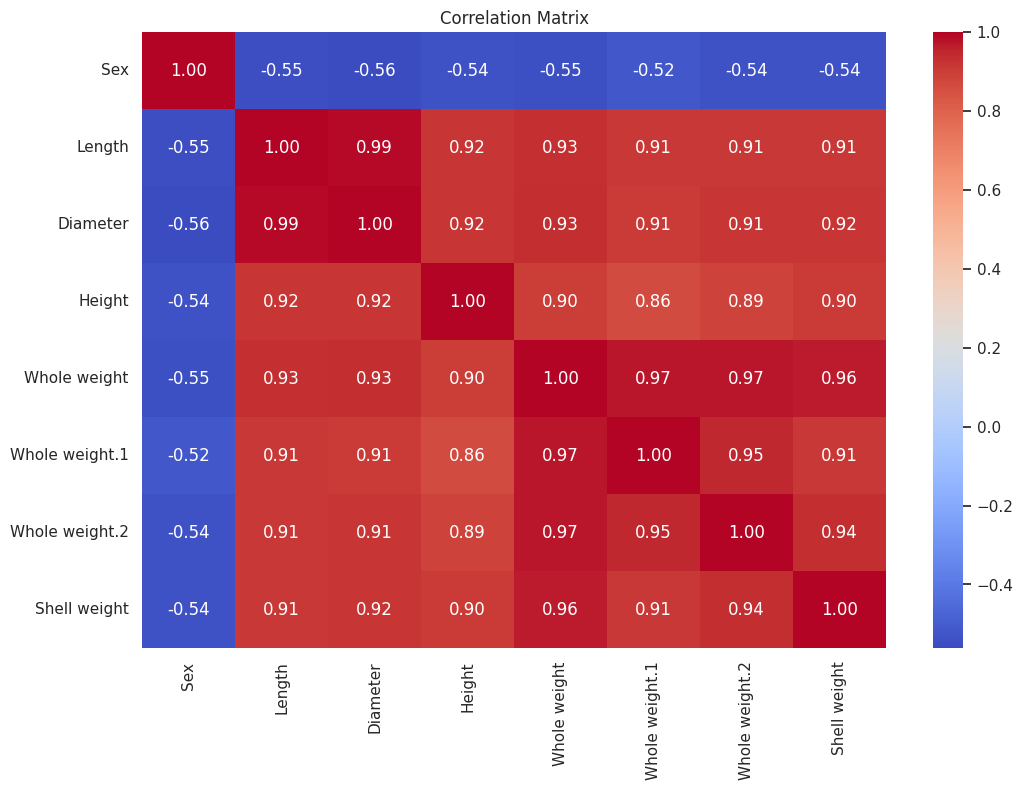

In [442]:
# Explore the correlation between features
plt.figure(figsize=(12, 8))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Based on the correlation matrix heatmap, we see high positive correlations among some pairs of features, particularly between 'Length' and 'Diameter', and between various 'Whole weight' related features. This suggests redundancy, as these features may be conveying similar information.

For these pairs of highly correlated features, we will create new features

In [450]:
df_train['volume'] = df_train['Length'] * df_train['Height'] * df_train['Diameter']
df_train['all_weight'] = (df_train['Whole weight'] + df_train['Whole weight.1'] + df_train['Whole weight.2'])
df_train['ratio'] = df_train['volume'] / df_train['all_weight']

In [451]:
df_train

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,volume,all_weight,ratio
0,1,0.549805,0.429932,0.150024,0.771484,0.328613,0.146484,0.239990,0.035461,1.246094,0.028458
1,1,0.629883,0.489990,0.145020,1.129883,0.458008,0.276611,0.320068,0.044769,1.864258,0.024017
2,2,0.160034,0.109985,0.024994,0.020996,0.005501,0.003000,0.005001,0.000440,0.029495,0.014923
3,0,0.595215,0.475098,0.150024,0.914551,0.375488,0.205444,0.250000,0.042419,1.495117,0.028366
4,2,0.555176,0.425049,0.130005,0.782227,0.369385,0.160034,0.197510,0.030685,1.311523,0.023392
...,...,...,...,...,...,...,...,...,...,...,...
90610,0,0.334961,0.234985,0.075012,0.158447,0.068481,0.036987,0.045013,0.005905,0.263916,0.022369
90611,0,0.555176,0.425049,0.150024,0.878906,0.386475,0.181519,0.239990,0.035400,1.447266,0.024460
90612,2,0.435059,0.330078,0.094971,0.321533,0.151001,0.078491,0.081482,0.013641,0.551270,0.024750
90613,2,0.344971,0.270020,0.075012,0.199951,0.098022,0.049011,0.070007,0.006989,0.346924,0.020142


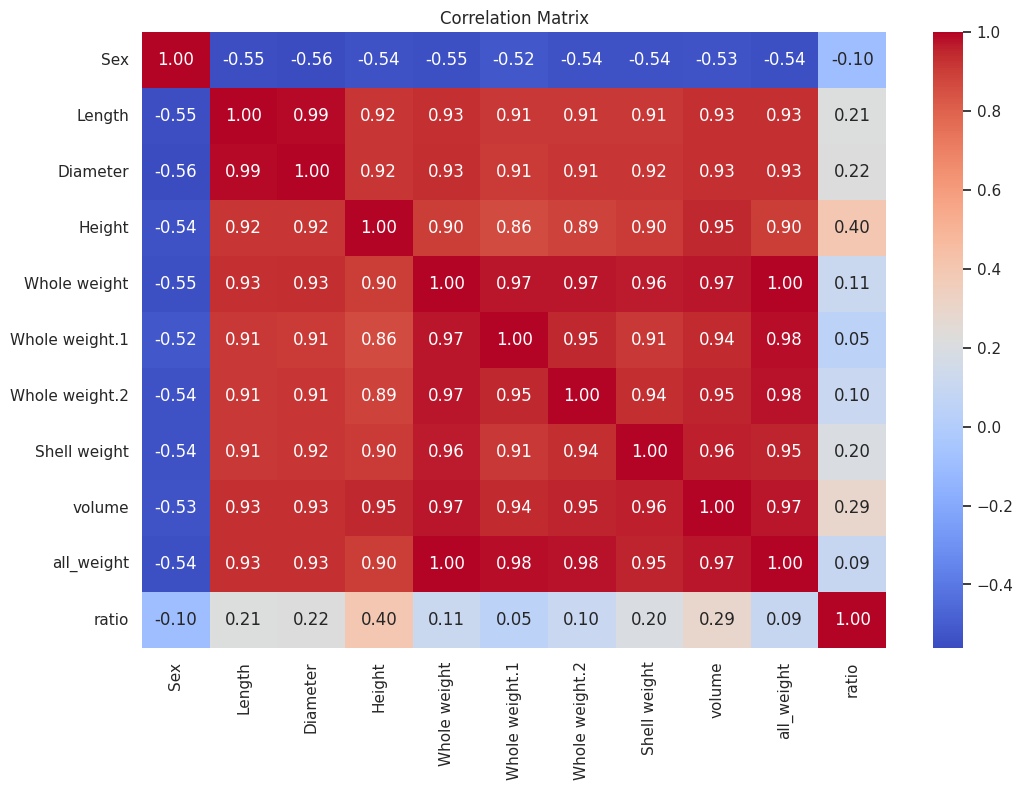

In [452]:
# Explore the correlation between features
plt.figure(figsize=(12, 8))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Preproccessing data

In [454]:
train_file_path = '/content/drive/MyDrive/Regression_with_an_Abalone_Dataset/train.csv'
df_train = pd.read_csv(train_file_path)

In [490]:
target = df_train['Rings']
df_train.drop('Rings', inplace=True, axis=1)

In [502]:
def preprocess_data(df):
    df = df.drop(['id'], axis=1)
    sex_mapping = {'F': 1, 'M': 0, 'I': 2}
    df['Sex'] = df['Sex'].replace(sex_mapping)
    df['volume'] = df['Length'] * df['Height'] * df['Diameter']
    df['all_weight'] = (df['Whole weight'] + df['Whole weight.1'] + df['Whole weight.2'])
    df['ratio'] = df['volume'] / df['all_weight']
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_scaled

In [486]:
df_train_pp = preprocess_data(df_train)

# Train - Ridge model

In [487]:
# define variables
X = df_train_pp
y = target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initiate the model
model = Ridge()

# train
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# Making sure there are no negative predictions since we cannot take the log of negative numbers
y_pred = np.maximum(y_pred, 0)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(y_test, y_pred)

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(msle)
print(f'Root Mean Squared Logarithmic Error: {rmsle}')

Root Mean Squared Logarithmic Error: 0.16396130155183825


## Basic Line:

Root Mean Squared Logarithmic Error: 0.164

# Loop through models

In [479]:
# Define the list of models
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    SVR(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    XGBRegressor(objective='reg:squarederror'),
    LGBMRegressor()
]

# Prepare the dataframe to store results
results = pd.DataFrame(columns=['Model', 'RMSLE'])

# Loop through the models
for model in models:
    # Train each model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Making sure there are no negative predictions since we cannot take the log of negative numbers
    y_pred = np.maximum(y_pred, 0)

    # Calculate Mean Squared Logarithmic Error (MSLE)
    msle = mean_squared_log_error(y_test, y_pred)

    # Calculate Root Mean Squared Logarithmic Error (RMSLE)
    rmsle = np.sqrt(msle)

    new_row = pd.DataFrame({'Model': [model.__class__.__name__], 'RMSLE': [rmsle]})
    results = pd.concat([results, new_row], ignore_index=True)

# Sort and print results
results_sorted = results.sort_values(by='RMSLE').reset_index(drop=True)
print(results_sorted)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 11
[LightGBM] [Info] Start training from score 9.697111
                        Model     RMSLE
0               LGBMRegressor  0.152950
1                XGBRegressor  0.153100
2   GradientBoostingRegressor  0.155657
3                         SVR  0.155986
4       RandomForestRegressor  0.156055
5                       Ridge  0.163961
6            LinearRegression  0.163964
7         KNeighborsRegressor  0.167934
8                  ElasticNet  0.205584
9       DecisionTreeRegressor  0.215757
10                      Lasso  0.219333
11          AdaBoostRegressor  0.2

In [480]:
results_sorted

,Model,RMSLE
0,LGBMRegressor,0.152950
1,XGBRegressor,0.153100
2,GradientBoostingRegressor,0.155657
3,SVR,0.155986
4,RandomForestRegressor,0.156055
5,Ridge,0.163961
6,LinearRegression,0.163964
7,KNeighborsRegressor,0.167934
8,ElasticNet,0.205584
9,DecisionTreeRegressor,0.215757


# choose the best models


*   LGBMRegressor()
*   XGBRegressor(objective='reg:squarederror'
*   RandomForestRegressor()
*   GradientBoostingRegressor()
*   SVR()
*   Ridge()

\

In [481]:
# set some params (prev.experiences)

lgbm_params = {
    'num_leaves': 20,
    'max_depth': -1,
    'learning_rate': 0.1,
    'n_estimators': 500
}

xgb_params = {
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.05,
    'n_estimators': 300
}

xgb_params = {
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.05,
    'n_estimators': 300
}

rf_params = {
    'n_estimators': 100,
    'max_features': 'sqrt',
    'min_samples_leaf': 5
}

gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3
}

ridge_params = {
    'alpha': 1.5
}

In [482]:
# Prepare the dataframe to store results
results = pd.DataFrame(columns=['Model', 'RMSLE'])

models = [ LGBMRegressor(**lgbm_params),
          XGBRegressor(**xgb_params),
           RandomForestRegressor(**rf_params),
           GradientBoostingRegressor(**gb_params),
           Ridge(**ridge_params)
]

# Loop through the models
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.maximum(y_pred, 0)
    msle = mean_squared_log_error(y_test, y_pred)
    rmsle = np.sqrt(msle)
    # saving results
    new_row = pd.DataFrame({'Model': [model.__class__.__name__], 'RMSLE': [rmsle]})
    results = pd.concat([results, new_row], ignore_index=True)

# Sorted results
results_sorted = results.sort_values(by='RMSLE').reset_index(drop=True)
print(results_sorted)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 11
[LightGBM] [Info] Start training from score 9.697111
                       Model     RMSLE
0              LGBMRegressor  0.151932
1               XGBRegressor  0.152694
2      RandomForestRegressor  0.152796
3  GradientBoostingRegressor  0.155658
4                      Ridge  0.163960


# Meta Model, Stacking Regressor - LinearRegression()

estimators:

*   lgbm_model
*   xgb_model
*   rf_model
*   gb_model


In [484]:
# # Initialize base models
lgbm_model = LGBMRegressor(**lgbm_params)
xgb_model = XGBRegressor(**xgb_params)
rf_model = RandomForestRegressor(**rf_params)
gb_model = GradientBoostingRegressor(**gb_params)

# we use LinearRegression as a simple meta-model
meta_model = LinearRegression()

# Create the stacking ensemble
stacked_model = StackingRegressor(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    final_estimator=meta_model,
    cv=5
)

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions
y_pred = stacked_model.predict(X_test)

# Ensuring no negative predictions for RMSLE calculation
y_pred = np.maximum(y_pred, 0)

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f"RMSLE for the stacked model: {rmsle}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 11
[LightGBM] [Info] Start training from score 9.697111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 57993, number of used features: 11
[LightGBM] [Info] Start training from score 9.708948
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

**RMSLE for the stacked model: 0.1514**

**Results obtained by the meta model are slightly better.**

**The advantage of the ensemble approach is not only in better metric values but also in stability and robustness on unseen data**.

# FINAL TRAIN ON FULL DATASET

In [488]:
# Initiate the meta-model
stacked_model = LinearRegression()

# Create the stacking ensemble model
stacked_model = StackingRegressor(estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('gb', gb_model)],
        final_estimator=meta_model,
        cv=5)

# Fit the stacked model on the full training set
stacked_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 11
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 11
[LightGBM] [Info] Start training from score 9.705223
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

StackingRegressor(cv=5,
                  estimators=[('lgbm',
                               LGBMRegressor(n_estimators=500, num_leaves=20)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            impo...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('rf',
                               RandomForestRegressor(max_features='sqrt',
                                                     min_samples_leaf=5)),
                              ('gb', GradientBoostingRegressor())],
                  final_estimator=LinearRegression())

# TEST

In [503]:
test_file_path = '/content/drive/MyDrive/Regression_with_an_Abalone_Dataset/test.csv'
df_test = pd.read_csv(test_file_path)

df_test_pp = preprocess_data(df_test)

X_test = df_test_pp

In [505]:
final_predictions = stacked_model.predict(X_test)

y_pred = np.maximum(final_predictions, 0)

# SUBMISSION

In [508]:
submission_path = '/content/drive/MyDrive/Regression_with_an_Abalone_Dataset/sample_submission.csv'
sample = pd.read_csv(submission_path)
sample['Rings'] = y_pred
# save to submissions
sample.to_csv('/content/drive/MyDrive//Regression_with_an_Abalone_Dataset/sample_submission_meta_model.csv', index=False)

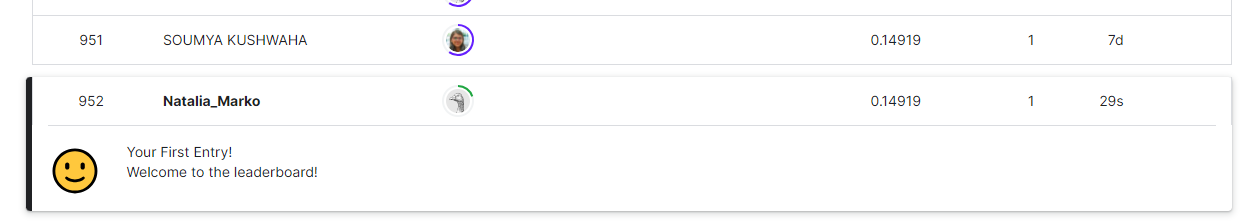

**rank 952/1768**

https://www.kaggle.com/competitions/playground-series-s4e4